In [14]:
from DC import DCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
import copy
plt.rcParams.update({'font.size': 16})

### Inputs

In [15]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D])
            
y_coord = torch.tensor([6.*D, 6.*D, 6.*D,
                        3.*D, 3.*D, 3.*D,
                        0., 0., 0., ])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

# dropout
dropout=True
active_prob = .5 # probability turbine is active during training

# set bounds on allowed yaw angle
# umin 0 by default (controlled by sigmoid)
umax = torch.tensor([25.0]) # maximum allowed yaw angle (degrees)

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": 128, 
                     "dropout": dropout})

# hyperparameters
lr = .00025
# batch_size = 50
# N_batches = 400
# N_epochs = 2
batch_size = 50
N_batches = 50
N_epochs = 10

# generate training data
# ws from [ws_min, ws_max]; m/s
# ws_max = 8.0
ws_max = 11.4
ws_min = 3.0
ws_training = torch.rand((N_batches, batch_size, 1)) * (ws_max - ws_min) + ws_min 
# wd varies around wd_fixed; degrees
wd_fixed = 275.
wd_training = wd_fixed * torch.ones(N_batches, batch_size, 1)

# number of turbines active
active_turbs_training = torch.rand((N_batches, batch_size, nturbs)) < active_prob
# ensure at least 1 turbine is active
for batch in range(N_batches):
    for sample in range(batch_size):
        active_turbs= active_turbs_training[batch, sample, :]
        while torch.all(active_turbs == torch.tensor([False] * nturbs)):
            active_turbs_training[batch, sample, :] = torch.rand(nturbs) < active_prob

# pick validation set
ws_validation = torch.tensor([4., 6., 8.]) # m/s
wd_validation = torch.tensor([wd_fixed]) # degrees
active_turbs_validation = torch.tensor([[True, True, True, 
                                         True, True, True, 
                                         True, True, True], 
                                        [True, True, True, 
                                         True, True, True, 
                                         True, True, False],
                                        [True, True, True, 
                                         True, True, True, 
                                         True, False, False],
                                        [True, True, True, 
                                         True, True, False, 
                                         True, False, False]])

### Helper functions to apply DC to FLORIS-PT

In [21]:
# get control action from DC model
def get_control(model, ws, inds_sorted, ws_max, active_turbs=None):
    # normalize features to range [0,1]
    x = torch.cat([ws.unsqueeze(dim=1)/ws_max, active_turbs], axis=1)
    u = model(x)
    scaled_u = torch.clone(u)*umax
    if active_turbs is not None:
        scaled_u = torch.where(active_turbs,scaled_u,torch.tensor(0.))
    scaled_u = torch.reshape(scaled_u, (x.shape[0], nturbs, 1, 1)) # unflatten
    scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
    return scaled_u_sorted, scaled_u, u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, \
    powers_validation, x_coord, y_coord, z_coord, ws_max, wd_max=360., active_turbs_validation=None):
    
    power_validation = 0.
    
    N = len(active_turbs_validation)
    for i in range(N):
        ws = ws_validation
        wd = wd_validation.repeat(ws_validation.shape[0])
        active_turbs = active_turbs_validation[i].repeat(ws_validation.shape[0], 1)

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # add farm power
        farm_power = torch.sum(p, dim=(1)) # sum over turbines
        farm_power_mean = torch.mean(farm_power).item()
        powers_plot[i].append(farm_power_mean)
        
        power_validation += farm_power_mean
        
    powers_validation.append(power_validation/N)

### Training

In [24]:
# powers_plot = [[] for i in range(len(active_turbs_validation))]
# powers_validation = []

test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
           x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)


powers_validation

5300.9132080078125

In [20]:
powers_plot

TypeError: list indices must be integers or slices, not tuple

batch: 50/50.


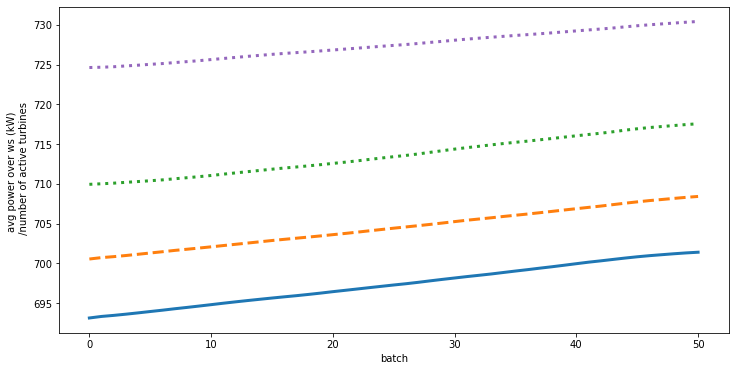

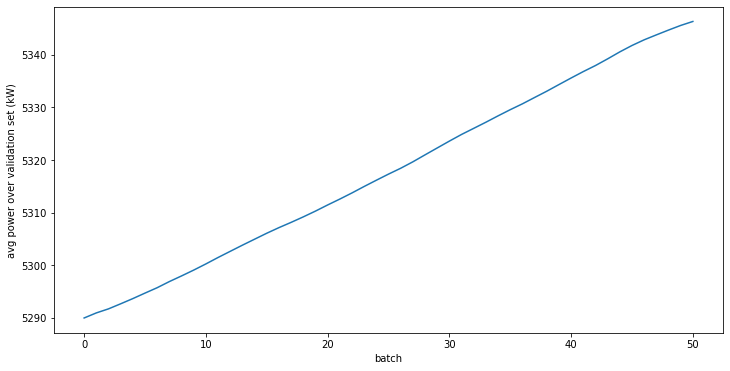

batch: 50/50.


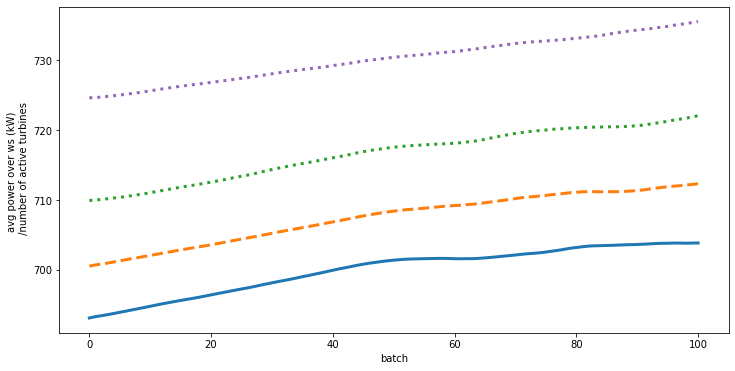

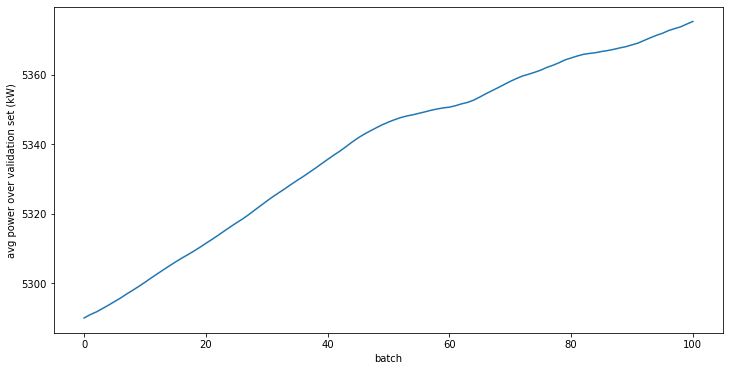

batch: 50/50.


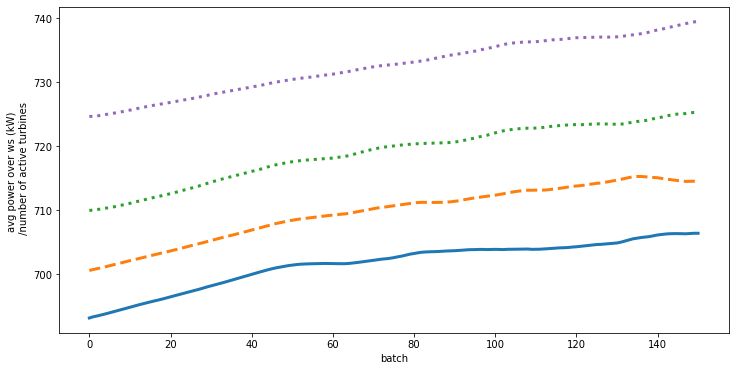

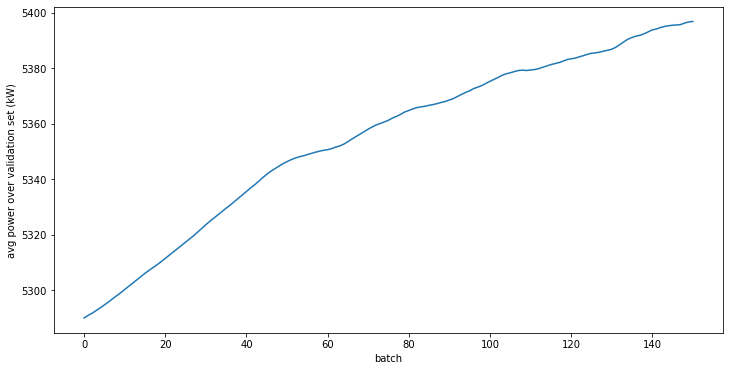

batch: 50/50.


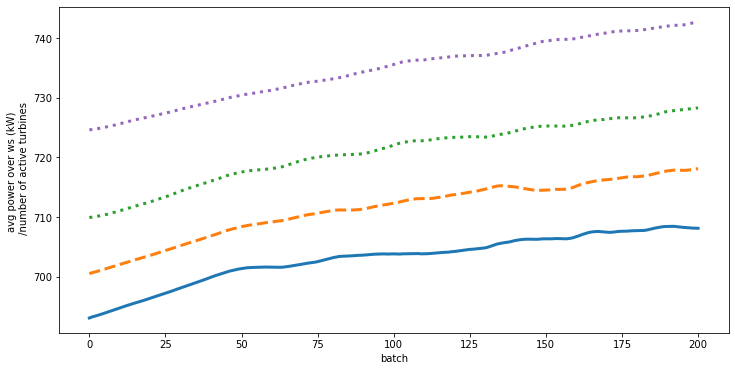

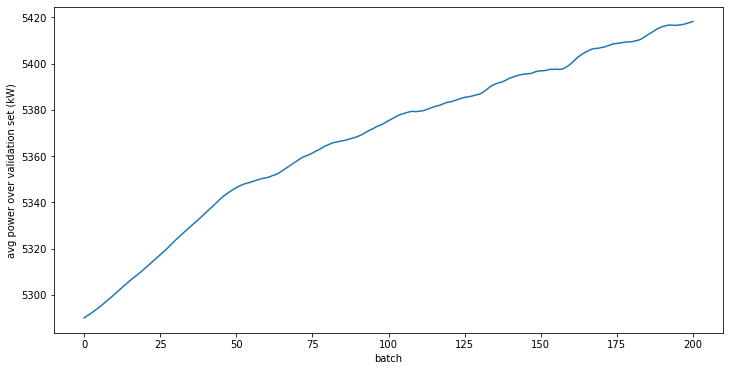

batch: 50/50.


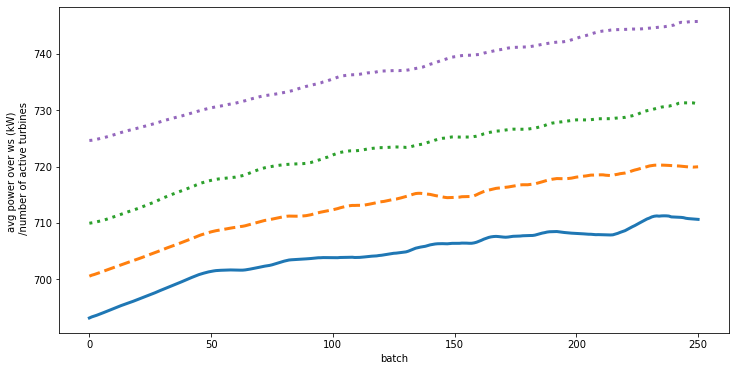

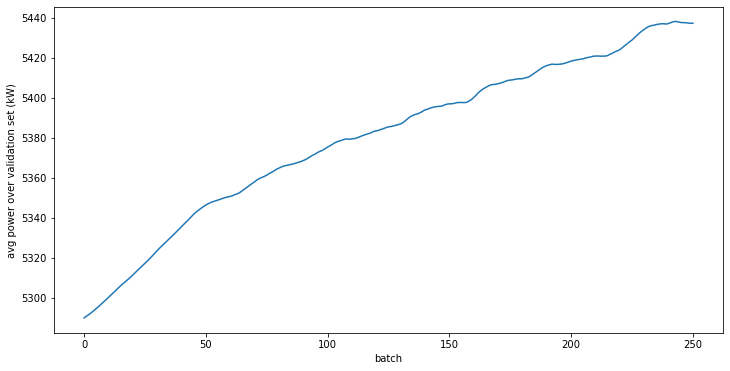

batch: 50/50.


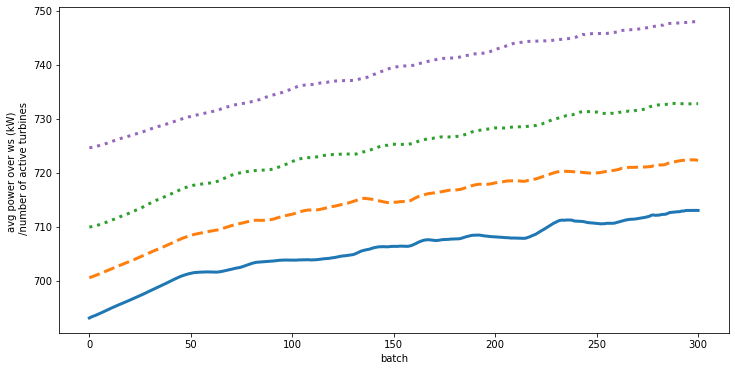

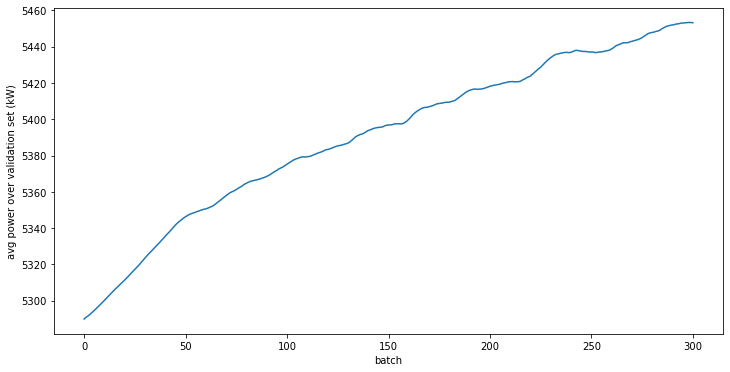

batch: 50/50.


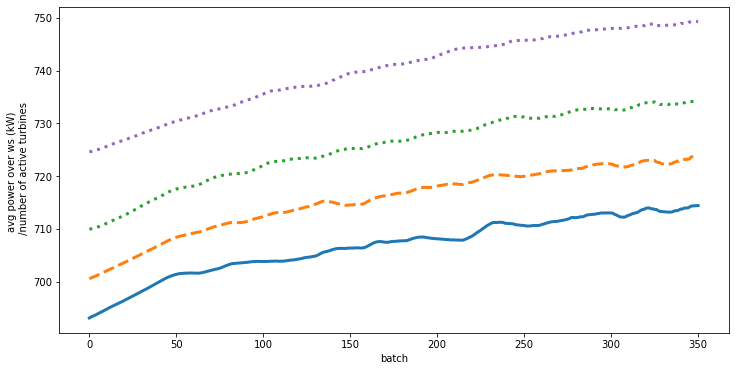

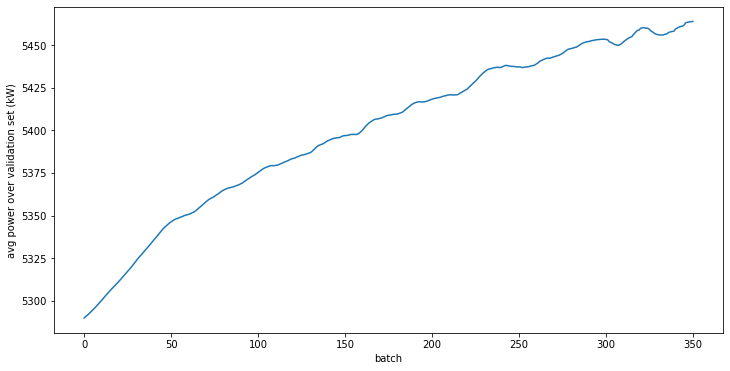

batch: 50/50.


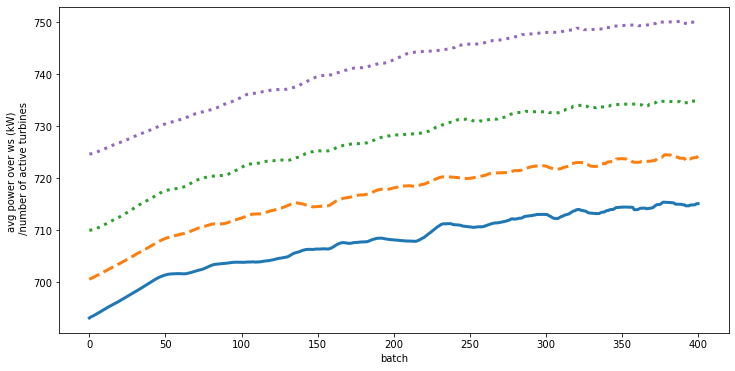

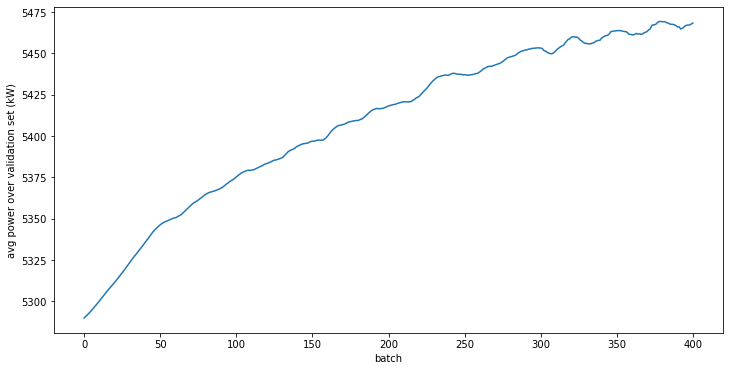

batch: 50/50.


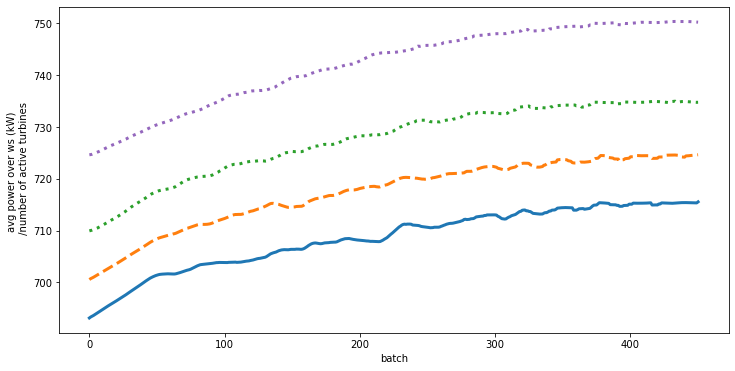

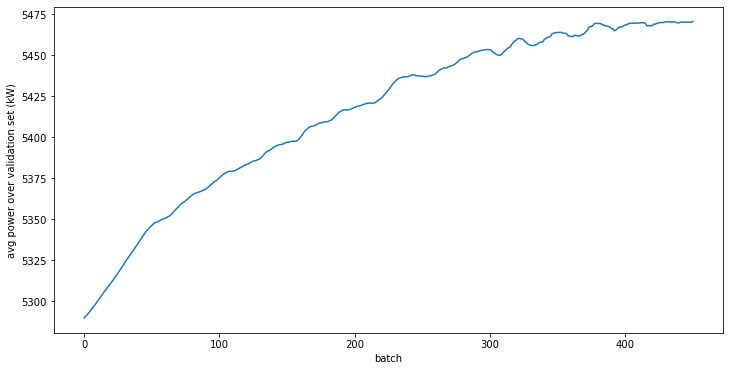

batch: 50/50.


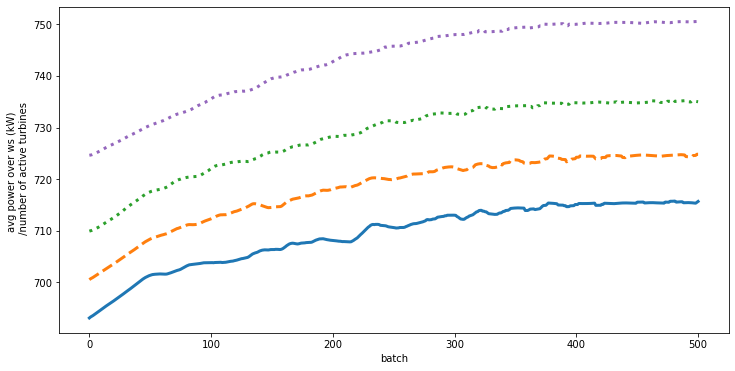

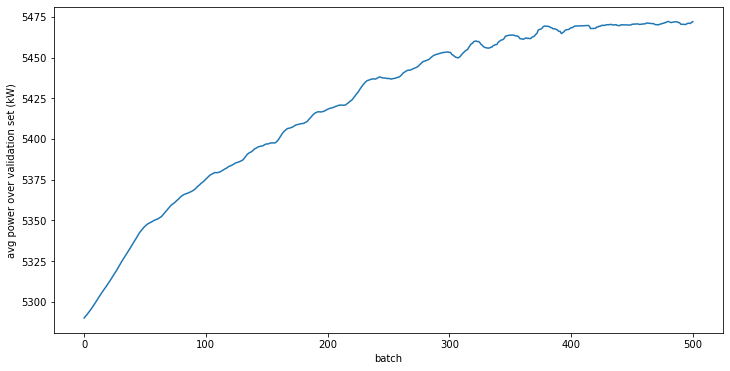

In [25]:
# initialize DC model
model = DCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
powers_plot = [[] for i in range(len(active_turbs_validation))]
powers_validation = []

# calculate and record power over validation set 
# using control actions from untrained DC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
           x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)

power_best = powers_validation[-1]
model_best = copy.deepcopy(model)

for epoch in range(N_epochs):
    # reorder samples to randomize data in batches
    perm_i = torch.randperm(N_batches)
    perm_j = torch.randperm(batch_size)
    ws_training_ij = ws_training[perm_i][:,perm_j]
    wd_training_ij = wd_training[perm_i][:,perm_j]
    active_turbs_training_ij = active_turbs_training[perm_i][:,perm_j]

    for batch in range(N_batches):
        opt_loss = 0.

        # forward pass
        ws = ws_training_ij[batch, :].squeeze(dim=1)
        wd = wd_training_ij[batch, :].squeeze(dim=1)
        active_turbs = active_turbs_training_ij[batch, :]

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # negative farm power (negative b/c optimizer minimizes loss)
        power_cost = -torch.sum(p)

        # sum over samples in batch
        opt_loss += power_cost / torch.sum(active_turbs)

        # normalize loss by batch size
        opt_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()

        # save losses
        opt_losses.append(opt_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
                   x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)
       
        # save best model
        power_validation = powers_validation[-1]
        if power_validation > power_best:
            power_best = power_validation
            model_best = copy.deepcopy(model)
            
        # uncomment to track progress during training
        nturbs_active = torch.sum(active_turbs_validation,axis=1)
        if (batch+1) % 50 == 0:
            print("batch: %d/%d."%(batch+1, N_batches))
            plt.plot(np.array(powers_plot[0])/nturbs_active[0], \
                     color='tab:blue', linestyle='-', linewidth=3)
            plt.plot(np.array(powers_plot[1])/nturbs_active[1], \
                     color='tab:orange', linestyle='--', linewidth=3)
            plt.plot(np.array(powers_plot[2])/nturbs_active[2], \
                     color='tab:green', linestyle=':', linewidth=3)
            plt.plot(np.array(powers_plot[3])/nturbs_active[3], \
                     color='tab:purple', linestyle=':', linewidth=3)
            plt.xlabel('batch')
            plt.ylabel('avg power over validation WSs (kW) \n /number of active turbines')
            fig = plt.gcf()
            fig.set_size_inches(12,6)
            plt.show()
            
            plt.plot(np.array(powers_validation), linewidth=3)
            plt.xlabel('batch')
            plt.ylabel('avg power over validation set (kW)')
            fig = plt.gcf()
            fig.set_size_inches(12,6)
            plt.show()
            
model = model_best

### FLORIS data

In [31]:
# ws =[3, 4, 5, 6, 7, 8]
# validaton ws=[4, 6, 8]

### 9 turbines ###

yaw_9t = [np.array([20.31, 20.31, 0., 
                       18.75, 18.75, 0., 
                       20.31, 18.75, 0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.   ]),
          np.array([18.75, 20.31, 0.,
                    15.6, 20.31, 0.,
                    18.75, 20.31, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([15.63, 20.31, 0., 
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    7.8125, 6.25, 0.])]

p_FLORIS_9t = np.array([12860.81, 8529.32, 5248.17, 2816.35, 1189.24, 212.07])
p_baseline_9t = np.array([11570.69, 7604.86, 4592.45, 2426.84, 981.51, 188.34])    
p_FLORIS_validation_9t = np.array([12860.81, 5248.17, 1189.24])
                      
### 8 turbines ###
yaw_8t = [np.array([20.31, 20.31, 0.,
                 20.31, 18.75, 0.,
                 18.75, 0.]), 
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    18.75, 0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    18.75, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    20.31, 0.])]
p_FLORIS_8t = np.array([11571.26, 7687.48, 4740.22, 2548.53, 1081.40, 195.62])
p_baseline_8t = np.array([10468.81, 6888.82, 4164.31, 2204.15, 893.72, 161.56])
p_FLORIS_validation_8t = np.array([11571.26, 4740.22, 1081.40])

    
### 7 turbines ###
yaw_7t = [np.array([20.31, 20.31, 0., 
                    20.31, 18.75, 0., 
                    0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0., 
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    7.81, 6.25, 0.,
                    0.])] 
p_FLORIS_7t = np.array([10267.05, 6818.95, 4208.14, 2261.84, 961.89, 177.42])
p_baseline_7t = np.array([9405.13, 6201.89, 3762.19, 2001.59, 822.94, 161.56])
p_FLORIS_validation_7t = np.array([10267.05, 4208.14, 961.89])

### 6 turbines ###
yaw_6t = [np.array([20.31, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 18.75, 0.,
                    18.75, 0.,
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    20.31, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    20.31, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    20.31, 0.,
                    0.])]
p_FLORIS_6t = np.array([8978.01, 5977.10, 3689.03, 1994.01, 854.04, 160.97])
p_baseline_6t = np.array([8303.25, 5485.85, 3334.04, 1778.90, 735.15, 134.79])
p_FLORIS_validation_6t = np.array([8978.01, 3689.03, 854.04])

### Training plot

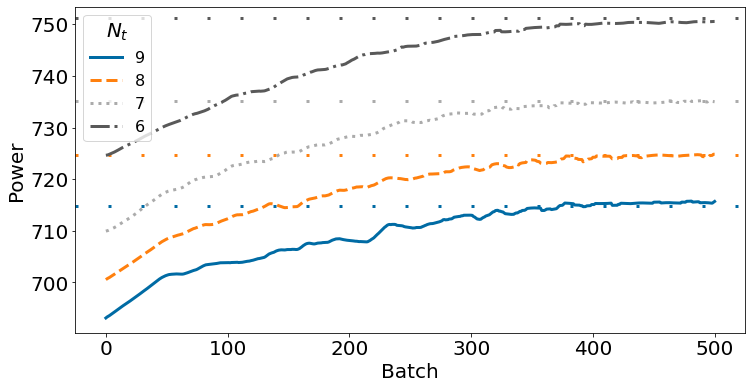

In [33]:
plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({'font.size': 20})
plt.rc('lines', linewidth=3.0)

linestyles = ['-', '--', ':', '-.']

markerstyles = ['+', 'x', '*', 'o']
marker_names = ["DC", "Opt.", "Lookup", "Baseline"]

plt.rcParams.update({'lines.markersize': 15})

ps_FLORIS_validation = [p_FLORIS_validation_9t, p_FLORIS_validation_8t, \
                        p_FLORIS_validation_7t, p_FLORIS_validation_6t]

for i in range(4):
    nturbs_active = 9-i
    plt.plot(np.array(np.array(powers_plot[i])/nturbs_active), label=str(nturbs_active), 
             color=colors[i], linestyle=linestyles[i], linewidth=3)
    plt.axhline(np.mean(ps_FLORIS_validation[i])/nturbs_active, color=colors[i], linestyle=(0, (1, 10)), linewidth=3)
    
plt.legend(title="$N_t$", prop={'size': 16})
plt.xlabel('Batch')
plt.ylabel('Power')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/training.png', 
             bbox_inches='tight')
plt.show()

# Loss averaged over the wind speeds in the validation set
# for each turbine status vector in the validation set, 
# labeled by the number of active turbines (6, 7, 8, or 9.)

### Testing plots

In [34]:
ps_DC = []

for i in range(len(active_turbs_validation)):
    ws = torch.tensor([8, 7, 6, 5, 4])
    wd = wd_validation.repeat(ws.shape[0])
    active_turbs = active_turbs_validation[i].repeat(ws.shape[0], 1)

    # generate mesh on turbine rotor
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

    # sort active turbines
    active_turbs_sorted = torch.take_along_dim(
        active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

    # get control action
    scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_max, \
        active_turbs=active_turbs)

    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
        active_turbs_sorted=active_turbs_sorted)

    farm_power = torch.sum(p, axis=1).detach().numpy()

    ps_DC.append(farm_power)
ps_DC.reverse()

ps_DC

[array([8967.2    , 5986.8423 , 3683.3035 , 2000.3562 ,  856.62256],
       dtype=float32),
 array([10268.726 ,  6844.0835,  4203.8384,  2278.0486,   969.4614],
       dtype=float32),
 array([11565.966 ,  7715.166 ,  4737.0615,  2565.0908,  1088.8525],
       dtype=float32),
 array([12866.717 ,  8571.916 ,  5256.797 ,  2842.3228,  1201.3948],
       dtype=float32)]

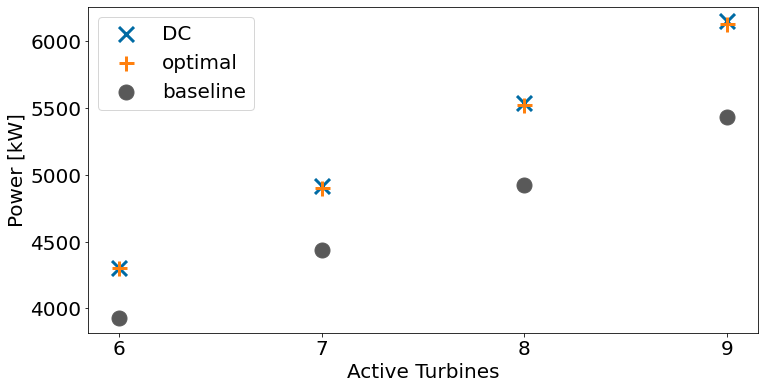

In [35]:
ps_FLORIS = [p_FLORIS_6t[:-1], p_FLORIS_7t[:-1], p_FLORIS_8t[:-1], p_FLORIS_9t[:-1]]
ps_baseline = [p_baseline_6t[:-1], p_baseline_7t[:-1], p_baseline_8t[:-1], p_baseline_9t[:-1]]

nturbs_active = [6, 7, 8, 9]
plt.scatter(nturbs_active, [np.mean(p) for p in ps_DC], color=colors[0], \
            marker='x', label="DC")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_FLORIS], color=colors[1], \
            marker='+', label="optimal")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_baseline], \
            marker='o', color=colors[3], label="baseline")
plt.xlabel("Active Turbines")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
ax=plt.gca()
plt.xticks(ticks=nturbs_active, labels=[str(nt) for nt in nturbs_active])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/testing_Nt.png', 
             bbox_inches='tight')
plt.show()

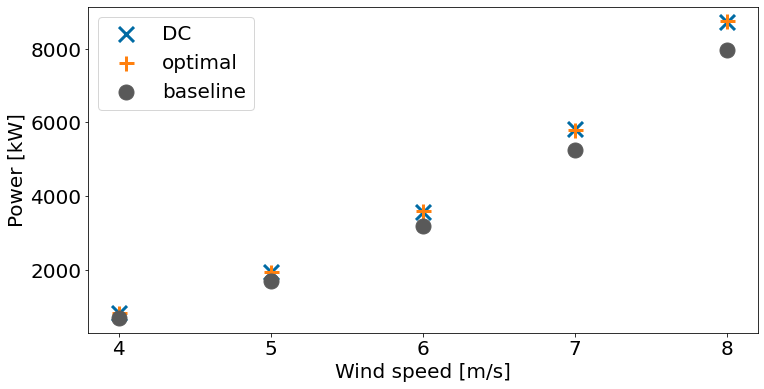

In [36]:
ws_plot =[4, 5, 6, 7, 8]
def t_to_ws(ps_t):
    ps_ws = np.zeros(len(ws_plot))
    for ps in ps_t:
        for i in range(len(ps)):
            ps_ws[i] += ps[i]
    ps_ws /= len(ws_plot)
    return np.flip(ps_ws)

ps_DC_ws = t_to_ws(ps_DC)
ps_FLORIS_ws = t_to_ws(ps_FLORIS)
ps_baseline_ws = t_to_ws(ps_baseline)


plt.scatter(ws_plot, ps_DC_ws, color=colors[0], marker='x', label="DC")
plt.scatter(ws_plot, ps_FLORIS_ws, color=colors[1], marker='+', label="optimal")
plt.scatter(ws_plot, ps_baseline_ws, marker='o', color=colors[3], label="baseline")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/testing_u.png', 
             bbox_inches='tight')
plt.show()

### yaw plots

In [37]:
ws = torch.tensor(ws_plot)
wd = wd_validation.repeat(ws.shape[0])
active_turbs = active_turbs_validation[0].repeat(ws.shape[0], 1)

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_max, \
    active_turbs=active_turbs)

t1_9t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()

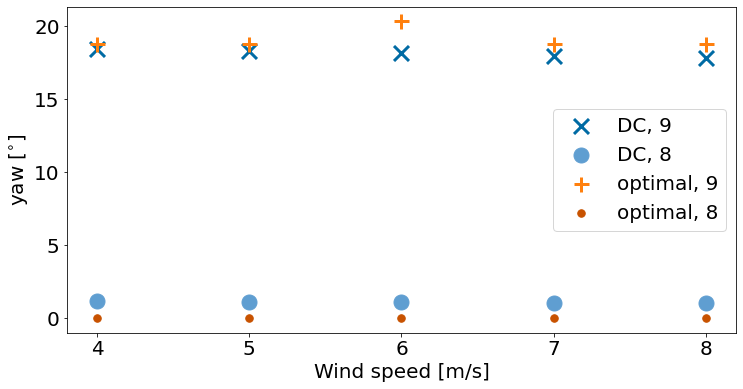

In [38]:
t1_9t_FLORIS = [yaw_9t_ws[7] for yaw_9t_ws in yaw_9t]
t1_8t_FLORIS = [yaw_8t_ws[7] for yaw_8t_ws in yaw_8t]
t1_9t_FLORIS.reverse()
t1_8t_FLORIS.reverse()

ws = torch.tensor(ws_plot)
wd = wd_validation.repeat(ws.shape[0])
active_turbs = active_turbs_validation[0].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_max, \
    active_turbs=active_turbs)
t1_9t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_validation[1].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_max, \
    active_turbs=active_turbs)
t1_8t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()
    
plt.scatter(ws_plot, t1_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_plot, t1_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_plot, t1_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t1_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/yaw_t1.png', 
             bbox_inches='tight')
plt.show()

In [39]:
np.append(np.array(t1_9t_DC) - np.array(t1_9t_FLORIS[1:]), 
                  np.array(t1_8t_DC) - np.array(t1_8t_FLORIS[1:]))

array([-0.32698631, -0.46800423, -2.17685944, -0.77297783, -0.93124199,
        1.13724422,  1.11012304,  1.08316326,  1.05700684,  1.03307283])

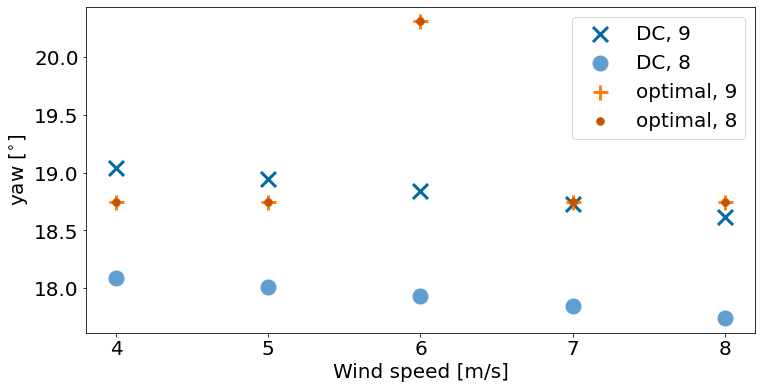

In [40]:
ws_plot =[4, 5, 6, 7, 8]
t2_9t_FLORIS = [yaw_9t_ws[4] for yaw_9t_ws in yaw_9t]
t2_8t_FLORIS = [yaw_8t_ws[4] for yaw_8t_ws in yaw_8t]
t2_9t_FLORIS.reverse()
t2_8t_FLORIS.reverse()

ws = torch.tensor(ws_plot)
wd = wd_validation.repeat(ws.shape[0])
active_turbs = active_turbs_validation[0].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_max, \
    active_turbs=active_turbs)
t2_9t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_validation[1].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_max, \
    active_turbs=active_turbs)
t2_8t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()
    
plt.scatter(ws_plot, t2_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_plot, t2_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_plot, t2_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t2_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/yaw_t2.png', 
             bbox_inches='tight')
plt.show()

In [41]:
t2_9t_DC[2]

18.843077

In [42]:
np.append(np.array(t2_9t_DC) - np.array(t2_9t_FLORIS[1:]), 
                  np.array(t2_8t_DC) - np.array(t2_8t_FLORIS[1:]))

array([ 0.2894783 ,  0.1958065 , -1.46692329, -0.01789665, -0.13019371,
       -0.66057587, -0.74038887, -2.38091904, -0.90413666, -1.00798988])

In [43]:
wd = torch.tensor([wd_fixed])
ws = torch.tensor([6.])
active_turbs = torch.tensor([[True, True, True,
                             True, True, True,
                             True, True, True]])

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)  

active_turbs_sorted = torch.take_along_dim(
    active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

scaled_u = torch.tensor(yaw_9t[2], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
print("scaled u: ", np.round(scaled_u.detach().numpy().flatten(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)
p1 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
    active_turbs_sorted=active_turbs_sorted)
print("power: ", np.round(torch.sum(p1).detach().numpy(), 1))
print("")

yaw_9t_alt = yaw_9t[2].copy()
yaw_9t_alt[4]=18.45
scaled_u = torch.tensor(yaw_9t_alt, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
print("scaled u: ", np.round(scaled_u.detach().numpy().flatten(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)
p2 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
    active_turbs_sorted=active_turbs_sorted)
print("power: ", np.round(torch.sum(p2).detach().numpy(), 1))
print("")

yaw_9t_alt0 = yaw_9t[2].copy()
yaw_9t_alt0[4]=0.
scaled_u = torch.tensor(yaw_9t_alt0, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
print("scaled u: ", np.round(scaled_u.detach().numpy().flatten(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)
p3 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
    active_turbs_sorted=active_turbs_sorted)
print("power: ", np.round(torch.sum(p3).detach().numpy(), 1))
print("")

scaled u:  [18.75 20.31  0.   15.6  20.31  0.   18.75 20.31  0.  ]
power:  5248.3

scaled u:  [18.75 20.31  0.   15.6  18.45  0.   18.75 20.31  0.  ]
power:  5247.8

scaled u:  [18.75 20.31  0.   15.6   0.    0.   18.75 20.31  0.  ]
power:  5172.1



In [44]:
(torch.sum(p1) - torch.sum(p2))/torch.sum(p1)*100

tensor(0.0085)

In [45]:
(torch.sum(p1) - torch.sum(p3))/torch.sum(p1)*100

tensor(1.4520)